**2D Moon Lander**

This model controlling a VTVL lander landing on moon.
There is no air resistance on moon, the gravitational acceleration is very small  $g=1.6m/s^2$ .
A rocket engine on the bottom can provide enough thrust to against gravity.
A momentum wheel on the centroid provide torque for orientation of the lander.
A flat landing field already been found.

In [9]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [10]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 1.2  # gravity constant
BOOST_ACCEL = 1.8  # thrust constant
LANDING_FIELD_WIDTH = 2.5  # landing field width
LANDING_FIELD_HEIGHT = 0.  # ground
w1 = [-LANDING_FIELD_WIDTH, LANDING_FIELD_WIDTH]
w2 = [0.1*-LANDING_FIELD_WIDTH, 0.1*LANDING_FIELD_WIDTH] # center of landing field
h =  [LANDING_FIELD_HEIGHT,LANDING_FIELD_HEIGHT] # ground
ROTATION_ACCEL = np.radians(20)  # rotational acceleration

Action: $[a, \alpha]$ <br />
$a$ = thrust (max = $1.8m/s^2$) <br />
$\alpha$ = angular acceleration (max = $\pm 20^{\circ}/s^2$)

State: $[\theta, \omega, x, v_x, y, v_y]$ <br />
$\theta$ = angle of orientation <br />
$\omega$ = angular velocity <br />
$x$ = horizontal position <br />
$v_x$ = horizontal velocity <br />
$y$ = height <br />
$v_y$ = vertical position <br />

Discrete-time dynamic equation: <br />
$\theta(t+1) = \theta(t) + \omega(t) \Delta t$ <br />
$\omega(t+1) = \omega(t) + \alpha \Delta t$ <br />
$x(t+1) = x(t) \Delta + v_x(t) t$ <br />
$v_x(t+1) = v_x(t) - a * sin(\theta(t)) \Delta t$ <br />
$y(t+1) = y(t) + v_y(t) \Delta t$ <br />
$v_y(t+1) = v_y(t) + a * cos(\theta(t)) \Delta t - g \Delta t$ <br />

In [11]:
# define system dynamics
# Notes:
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])

        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1) + 0.00002*(t.rand(6)-0.5) # Add noises

        return state

In [12]:
# a deterministic controller
# Note:
# nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [13]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [math.pi/6*(random.random()-0.5), math.pi/12*(random.random()-0.5), # orientation state
                     10.*(random.random()-0.5), (random.random()-0.5), # horizontal state
                     5.*random.random()+10., -random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [14]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1, line_search_fn='strong_wolfe')

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(n):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [15]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.6f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

Generate 200 initial states of rocket:
[[ 1.60369731e-01 -1.99615017e-02  6.76787573e-01  3.53198822e-02
   1.46391752e+01 -2.45651939e-01]
 [-1.97998978e-01  1.71614847e-02  1.81711940e+00  3.67385448e-01
   1.49811850e+01 -1.22709171e-02]
 [ 1.42636367e-02 -1.03199656e-01  4.75124367e+00  2.25724499e-01
   1.39873456e+01 -2.02030914e-01]
 ...
 [-6.08185428e-02 -5.60023584e-02 -4.43618723e+00  1.10943901e-02
   1.19881367e+01 -7.27673508e-01]
 [ 4.17775976e-02 -1.23952801e-01  1.02788304e+00  2.80577676e-01
   1.43554003e+01 -8.95745828e-01]
 [-3.32261599e-02 -1.22424711e-01 -2.95916061e+00  8.40136409e-02
   1.42760573e+01 -5.62715592e-01]]
Start Training:
[1] loss: 39.331734


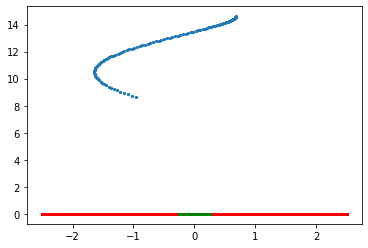

[2] loss: 23.296289


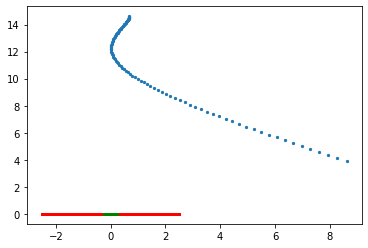

[3] loss: 14.671361


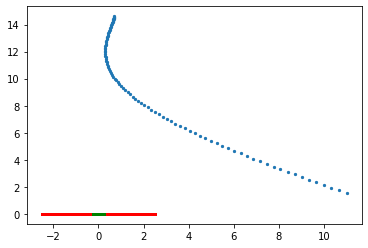

[4] loss: 2.329459


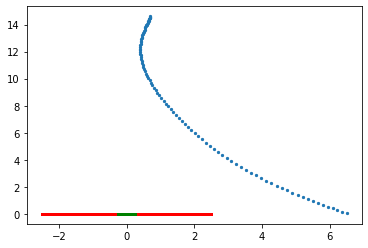

[5] loss: 0.424980


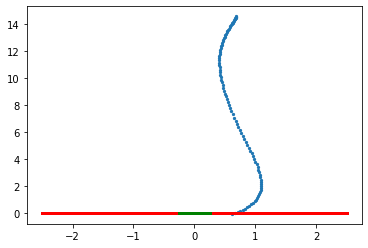

[6] loss: 0.071058


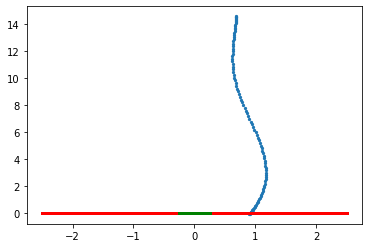

[7] loss: 0.018132


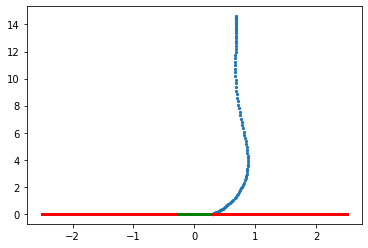

[8] loss: 0.011356


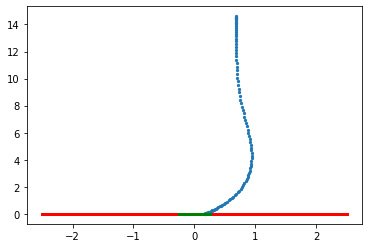

[9] loss: 0.002258


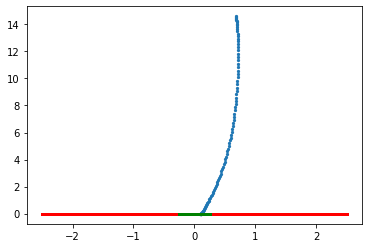

[10] loss: 0.001556


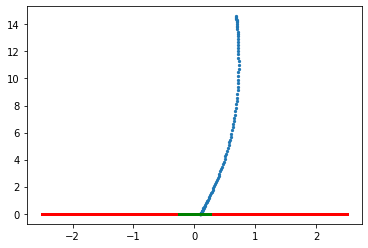

[11] loss: 0.001160


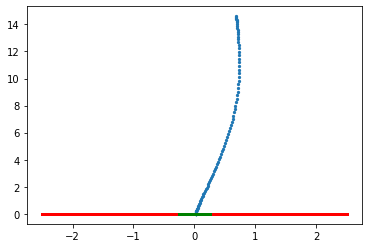

[12] loss: 0.000942


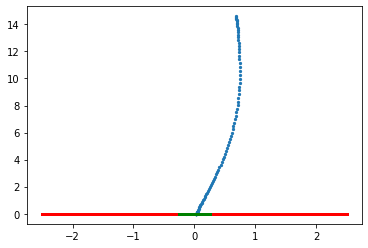

[13] loss: 0.000787


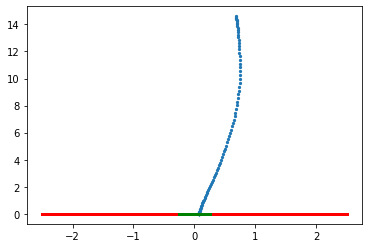

[14] loss: 0.000716


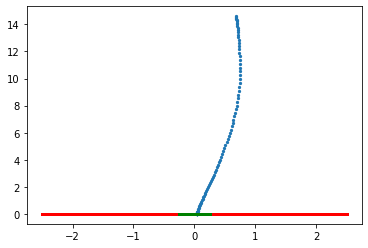

[15] loss: 0.000640


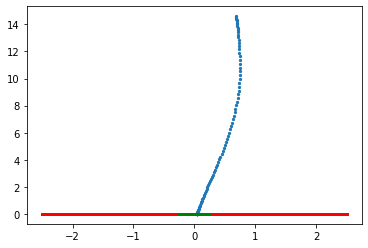

[16] loss: 0.000540


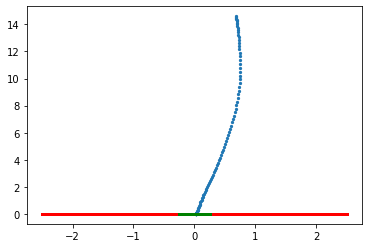

[17] loss: 0.000466


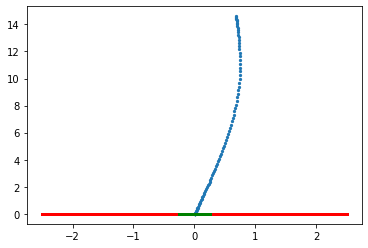

[18] loss: 0.000409


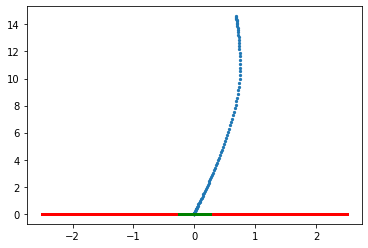

[19] loss: 0.000358


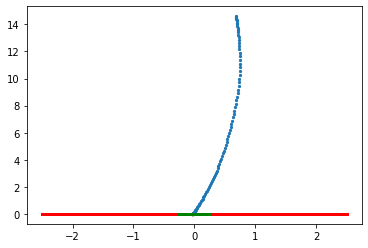

[20] loss: 0.000307


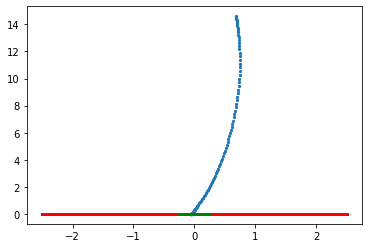

[21] loss: 0.000288


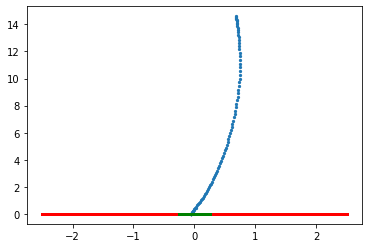

[22] loss: 0.000250


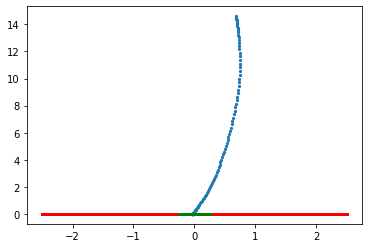

[23] loss: 0.000242


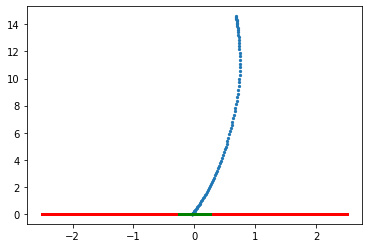

[24] loss: 0.000208


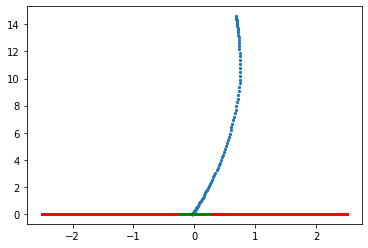

[25] loss: 0.000189


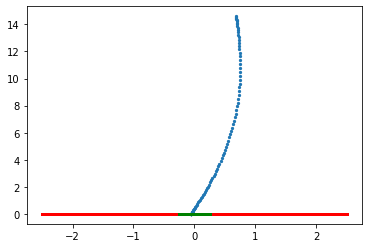

[26] loss: 0.000177


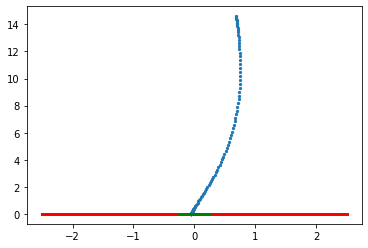

[27] loss: 0.000154


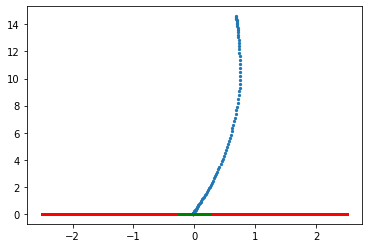

[28] loss: 0.000136


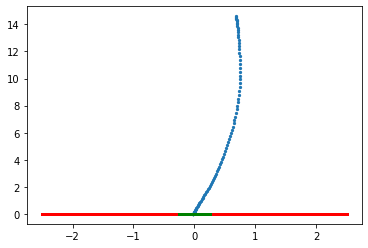

[29] loss: 0.000120


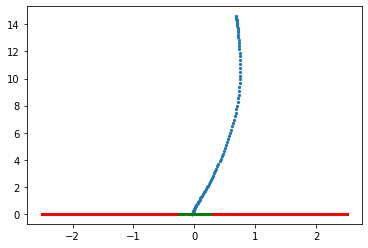

[30] loss: 0.000108


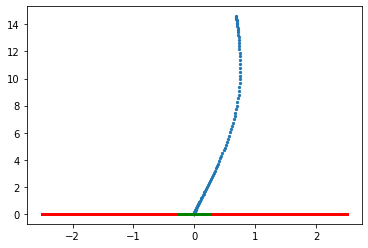

[31] loss: 0.000096


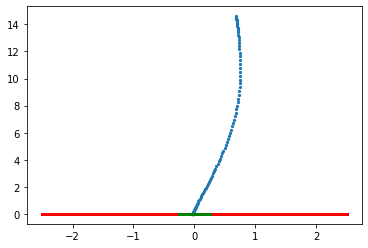

Convergence Plot:


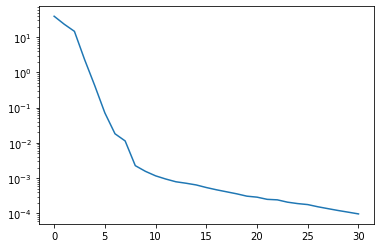

In [16]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 200  # number of initial states
err = 0.0001 # acceptable_error
itr = 120 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

10
Generate 10 initial states of rocket:
[[ 4.14021024e-02 -5.78582691e-02 -4.56998391e+00 -1.27552846e-01
   1.49292371e+01 -6.59615475e-01]
 [-3.40716634e-02  9.35447634e-02  8.63104248e-01  1.94847701e-01
   1.04686776e+01 -6.80613696e-01]
 [-5.04891260e-02  6.01266955e-02 -4.53122732e+00  2.48616091e-01
   1.02328193e+01 -5.82162342e-01]
 [-1.60194298e-01 -9.30045085e-02 -4.66519040e+00 -4.35176125e-01
   1.00789462e+01 -5.78778040e-01]
 [-4.42570490e-02 -3.54069333e-02  4.24452138e+00 -3.05122742e-01
   1.28847004e+01 -8.02868330e-01]
 [-2.27518705e-01  3.99322154e-02 -6.41774668e-01  4.48915216e-01
   1.03364384e+01 -3.98714096e-01]
 [ 1.42781260e-01  1.97723662e-02 -4.39688980e+00 -1.87970844e-01
   1.46540178e+01 -1.22780296e-01]
 [ 1.66442669e-01  5.79076949e-02  2.35451887e+00  1.03334173e-02
   1.26619565e+01 -7.53090853e-01]
 [-1.46309063e-01  2.51483933e-03 -1.76963701e+00  2.18071397e-01
   1.26866319e+01 -4.33493290e-01]
 [ 3.34647875e-02 -1.27935157e-01  3.13817498e+00 

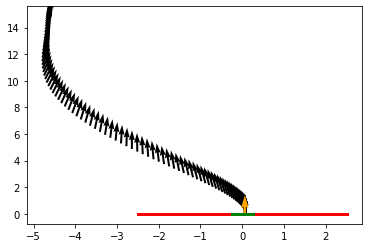

[0.00704494 0.00234584 0.06101695 0.01357672 0.0023181  0.00383345]


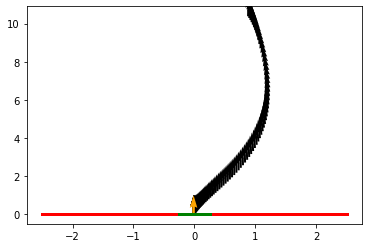

[0.00163488 0.00070291 0.01309502 0.00277221 0.00092138 0.00082953]


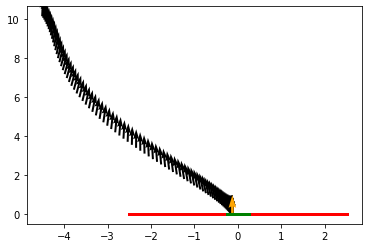

[0.00349124 0.00253009 0.12753768 0.00397307 0.00231972 0.00208818]


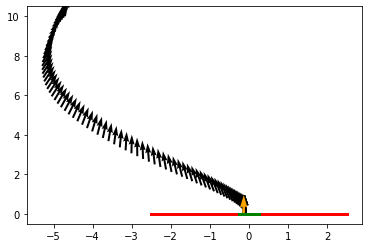

[0.00846913 0.00751259 0.13417226 0.01821417 0.00668003 0.00119113]


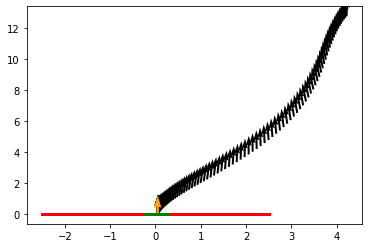

[9.4129948e-04 8.1732759e-04 4.7910687e-02 3.0488963e-04 2.0567873e-07
 2.2269292e-03]


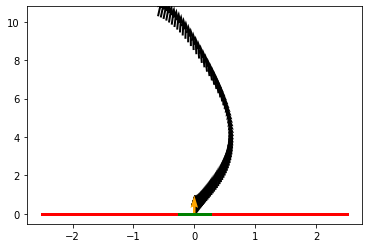

[0.00212229 0.0013485  0.00157768 0.00325441 0.00088136 0.00113216]


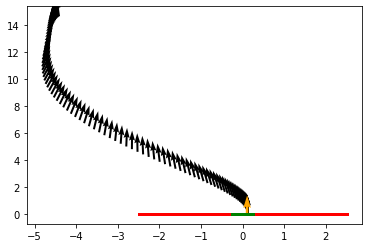

[6.9390507e-03 1.3063299e-02 1.0693193e-01 1.7137000e-02 2.1780434e-05
 1.6133677e-02]


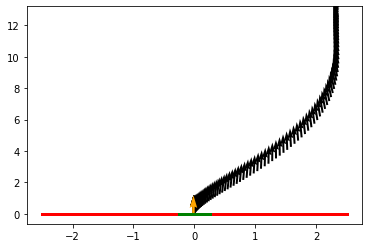

[0.00084471 0.00010061 0.01523587 0.00213796 0.00112383 0.00138074]


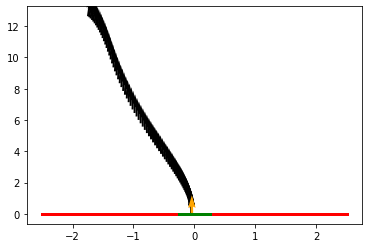

[0.00133628 0.00065123 0.04068315 0.0024769  0.00040243 0.00028701]


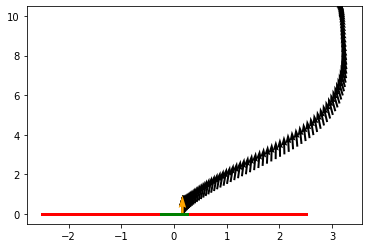

[3.0880047e-03 3.6058112e-03 1.5858462e-01 9.6843840e-05 7.7779568e-04
 3.0574230e-03]


In [17]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()
print(N_eval)
s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test